In [241]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import initializers, regularizers, optimizers, losses
print('[INFO] Using keras {0}'.format(keras.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

import pandas as pd
#import statsmodels

import sys
import time

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# Globals
nlayers = 25  # 13 (CSC) + 9 (RPC) + 3 (GEM)

infile = '../test2/histos_tba.8.npz'

[INFO] Using numpy 1.12.1
[INFO] Using keras 2.0.5
[INFO] Using sklearn 0.18.1


In [242]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_parameters = loaded['parameters']
    the_variables = loaded['variables']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3953523, 103)
[INFO] Loaded the parameters with shape (3953523, 3)


In [290]:
class Encoder(object):

  def __init__(self, x, y):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 4) + 3)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_mask  = self.x_copy[:, nlayers*3:nlayers*4].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*4:nlayers*5]  # ipt, ieta, iphi
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta, axis=1)
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Zones
      self.x_ieta  = self.x_road[:, 1].astype(np.int32)
      
      # Standard scales
      self.x_mean  = np.nanmean(self.x_copy, axis=0)
      self.x_std   = np.nanstd(self.x_copy, axis=0)
      self.x_std   = self._handle_zero_in_scale(self.x_std)
      self.x_copy -= self.x_mean
      self.x_copy /= self.x_std
      
      # Remove outlier hits by checking hit thetas
      x_theta_tmp = np.abs(self.x_theta) > 4.0
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      ## Something wrong with GE2/1?
      #bad_ge21 = 23
      #self.x_phi  [:, bad_ge21] = np.nan
      #self.x_theta[:, bad_ge21] = np.nan
      #self.x_bend [:, bad_ge21] = np.nan
      #self.x_mask [:, bad_ge21] = 1.0
      
      # Add variables: theta_median and mode variables
      self.x_theta_median -= 3  # scaled to [0,1]
      self.x_theta_median /= 83
      hits_to_station = np.array((5,5,1,1,1,2,2,2,2,3,3,4,4,1,1,2,3,3,3,4,4,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.float32)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask
  
  def get_x_ieta(self):
    x_ieta = self.x_ieta.copy()
    return x_ieta

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']
    

In [291]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters)
x, y, w, x_mask, x_ieta = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_ieta()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_ieta_train, x_ieta_test = train_test_split(x, y, w, x_mask, x_ieta, test_size=0.3)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


[INFO] Using 81 variables and 1 parameters


In [292]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[-0.69595063  0.          0.         ...,  1.          1.          0.        ]
 [-0.33015883  0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.33125722 ...,  1.          1.          1.        ]
 ..., 
 [ 0.92240101  0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.2614204   0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.66696632 ...,  1.          1.          1.        ]] [-0.10976338 -0.03732378  0.04606546 ...,  0.1067722   0.11707978
  0.07033174] [ 1.54881692  1.18661892  1.23032737 ...,  1.53386092  1.58539891
  1.3516587 ]
[  9.83674036e-05  -8.44017050e-05   1.76673493e-05  -1.66597947e-05
   0.00000000e+00   1.09099312e-06  -2.32297771e-05   3.84778104e-05
   5.04760828e-05  -1.57872579e-04  -6.53902680e-05  -3.89362576e-05
   3.33026073e-05  -1.14233308e-05  -5.75353795e-07  -3.01855380e-06
  -1.55424436e-06   1.58973728e-06   1.29262389e-06   1.37100585e-06
  -4.36

In [412]:
from sklearn.linear_model import LinearRegression
from sklearn.covariance import EmpiricalCovariance, MinCovDet


class ChiSquare(object):
  
  def __init__(self, x, x_mask, x_ieta, y):
    
    self.nentries = 40000
    self.nvariables = 75
    self.nzones = 6
    
    self.x = x[:self.nentries, :self.nvariables]
    self.x_mask = x_mask[:self.nentries]
    self.x_mask = np.tile(self.x_mask, 3)
    self.y = y[:self.nentries]
    self.x_ieta = x_ieta[:self.nentries]
    assert self.x.shape == self.x_mask.shape
    assert self.x.shape[0] == self.x_ieta.shape[0]
    assert self.x.shape[0] == self.y.shape[0]
    
    self.cov = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self._find_covariance()
    
    self.offset = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self.scale = np.zeros((self.nzones,self.nvariables), dtype=np.float32)
    self._find_difference()
    
    
  def _find_covariance(self):
    
    for zone in xrange(self.nzones):
      for i in xrange(self.nvariables):
        if i >= 25:
          continue
        
        print('[INFO] Find covariance on zone {0} var {1}'.format(zone, i))
                
        valid = (self.x_ieta == zone) & (~self.x_mask[:,i])
        x_i = self.x[:,i][valid]
        y_i = self.y[valid]
        #print x_i, y_i
        
        if x_i.size == 0:
          continue

        x_mean = np.mean(x_i)
        x_i -= x_mean
        
        x_std = np.std(x_i)
        if x_std == 0:
          continue

        # http://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html
        # Minimum Covariance Determinant (MCD): robust estimator of covariance.
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]
        self.cov[zone, i] = 1.0 / coef  # do the inverse
        print coef, mcd.covariance_
        
        # Check with simple linear regression y = a * x
        lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        print lr.intercept_, lr.coef_
        

  def _find_difference(self):
    
    for zone in xrange(self.nzones):
      for i in xrange(self.nvariables):
        
        print('[INFO] Find difference on zone {0} var {1}'.format(zone, i))
        
        valid = (self.x_ieta == zone) & (~self.x_mask[:,i])
        x_i = self.x[:,i][valid]
        y_i = self.y[valid]
        
        if x_i.size == 0:
          continue
        
        coef = self.cov[zone, i]
        x_pred = y_i * coef  # use the inverse
        x_diff = x_i - x_pred
        
        quantile_range = (25.0, 50.0, 75.0)
        q = np.percentile(x_diff, quantile_range)
        self.offset[zone, i] = q[1]
        if q[2] > q[0]:
          self.scale[zone, i] = 1.0 / (q[2] - q[0])  # do the inverse
        else:
          self.scale[zone, i] = 1.0
        print q
        print np.mean(x_diff), np.std(x_diff)
        
        
  def save_chsq(self, filepath):
    np.savez_compressed(filepath, cov=self.cov, offset=self.offset, scale=self.scale)

  def load_chsq(self, filepath):
    loaded = np.load(filepath)
    self.cov = loaded['cov']
    self.offset = loaded['offset']
    self.scale = loaded['scale']
    

In [413]:
chsq = ChiSquare(x_train, x_mask_train, x_ieta_train, y_train)
chsq.save_chsq('chsq.npz')
print('[INFO] ChiSquare is saved as chsq.npz')

[INFO] Find covariance on zone 0 var 0
[INFO] Find covariance on zone 0 var 1
[INFO] Find covariance on zone 0 var 2
0.119749 [[ 0.73317915  0.08779778]
 [ 0.08779778  0.0112067 ]]
0.0 [ 0.12227067]
[INFO] Find covariance on zone 0 var 3
0.125008 [[ 0.65771067  0.08221901]
 [ 0.08221901  0.01147754]]
0.0 [ 0.12161425]
[INFO] Find covariance on zone 0 var 4
[INFO] Find covariance on zone 0 var 5
[INFO] Find covariance on zone 0 var 6
[INFO] Find covariance on zone 0 var 7
-0.0930076 [[ 0.71889138 -0.06686235]
 [-0.06686235  0.011595  ]]
0.0 [-0.07784504]
[INFO] Find covariance on zone 0 var 8
-0.0956709 [[ 0.81782454 -0.07824197]
 [-0.07824197  0.01207366]]
0.0 [-0.07863572]
[INFO] Find covariance on zone 0 var 9
[INFO] Find covariance on zone 0 var 10
-0.12638 [[ 0.52425879 -0.0662559 ]
 [-0.0662559   0.0111405 ]]
0.0 [-0.09531889]
[INFO] Find covariance on zone 0 var 11
[INFO] Find covariance on zone 0 var 12
-0.124952 [[ 0.43468219 -0.05431426]
 [-0.05431426  0.01017304]]
0.0 [-0.055

In [418]:
yy = []
zz = []

for x, x_mask, zone, y in zip(x_train, x_mask_train, x_ieta_train, y_train[:1000]):
  
  x = x[:chsq.nvariables]
  x_mask = np.tile(x_mask, 3)
  valid = ~x_mask
  
  coef = chsq.cov[zone]
  offset = chsq.offset[zone]
  scale = chsq.scale[zone]
  
  x_pred = y * coef
  #print x, x_pred
  
  x_diff = (x_pred - x - offset) 
  x_diff *= scale  # use the inverse
  x_diff **= 2
  
  x_diff = x_diff[valid]
  #x_diff = np.sort(x_diff)[::-1]  # sort descending
  x_diff[::-1].sort()  # sort descending in-place
  x_diff = x_diff[:3]
  
  z = x_diff.sum()
  yy.append(y)
  zz.append(z)
  
  

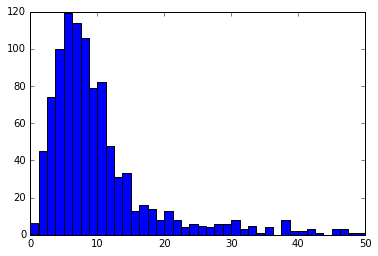

In [423]:
_ = plt.hist(zz, bins=40, range=[0,50])

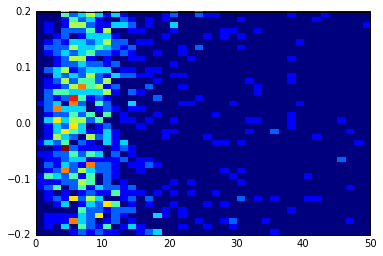

In [424]:
_ = plt.hist2d(zz, yy, bins=40, range=[[0,50],[-0.2,0.2]])